##### –ò–º–ø–æ—Ä—Ç –±–∏–±–ª–∏–æ—Ç–µ–∫

In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
import xgboost as xgb
from lightgbm import LGBMRegressor
import joblib

import warnings
from lightgbm import LGBMRegressor

import os
os.makedirs('models', exist_ok=True)

# –û—Ç–∫–ª—é—á–∞–µ–º –ª–æ–≥–∏ LightGBM
import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)

print("–ë–∏–±–ª–∏–æ—Ç–µ–∫–∏ –∑–∞–≥—Ä—É–∂–µ–Ω—ã!\n")

df = pd.read_csv('df/obr.csv', parse_dates=['datetime'], index_col='datetime')
print(f"–î–∞–Ω–Ω—ã–µ –∑–∞–≥—Ä—É–∂–µ–Ω—ã: {df.shape}")

–ë–∏–±–ª–∏–æ—Ç–µ–∫–∏ –∑–∞–≥—Ä—É–∂–µ–Ω—ã!

–î–∞–Ω–Ω—ã–µ –∑–∞–≥—Ä—É–∂–µ–Ω—ã: (260640, 11)


In [190]:
# –£–õ–£–ß–®–ï–ù–ù–û–ï –°–û–ó–î–ê–ù–ò–ï –ü–†–ò–ó–ù–ê–ö–û–í
print("–°–æ–∑–¥–∞–Ω–∏–µ –£–õ–£–ß–®–ï–ù–ù–´–• –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω–∞ –æ—Å–Ω–æ–≤–µ EDA...")
print(f"–ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä: {df.shape}")

# ===== –û–°–ù–û–í–ù–´–ï –ü–†–ò–ó–ù–ê–ö–ò (—É —Ç–µ–±—è —É–∂–µ –µ—Å—Ç—å) =====
# –¶–∏–∫–ª–∏—á–µ—Å–∫–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# –ü–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã  
df['is_evening_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 22)).astype(int)
df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 6)).astype(int)

# –û—Å–æ–±—ã–µ –¥–Ω–∏
df['is_sunday'] = (df['day_of_week'] == 6).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)

# ===== –£–õ–£–ß–®–ï–ù–ù–´–ï –ü–†–ò–ó–ù–ê–ö–ò (–ù–û–í–´–ï) =====
# 1. –ë–æ–ª–µ–µ –¥–µ—Ç–∞–ª—å–Ω—ã–µ –ø–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã
df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] <= 17)).astype(int)
df['is_late_night'] = ((df['hour'] >= 23) | (df['hour'] <= 3)).astype(int)

# 2. –ö–æ–º–±–∏–Ω–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –≤—Ä–µ–º–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
df['hour_type'] = df['hour'].apply(lambda x: 
    'night' if x <= 6 else 
    'morning_peak' if 7 <= x <= 9 else
    'day' if 10 <= x <= 17 else
    'evening_peak' if 18 <= x <= 22 else
    'late_night'
)

# 3. –†–∞—Å—à–∏—Ä–µ–Ω–Ω—ã–µ –ª–∞–≥–∏ (–∏–∑ –∞–Ω–∞–ª–∏–∑–∞ –∞–≤—Ç–æ–∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏)
df['lag_1h'] = df['Global_active_power'].shift(1)    # 1 —á–∞—Å –Ω–∞–∑–∞–¥
df['lag_2h'] = df['Global_active_power'].shift(2)    # 2 —á–∞—Å–∞ –Ω–∞–∑–∞–¥  
df['lag_3h'] = df['Global_active_power'].shift(3)    # 3 —á–∞—Å–∞ –Ω–∞–∑–∞–¥
df['lag_6h'] = df['Global_active_power'].shift(6)    # 6 —á–∞—Å–æ–≤ –Ω–∞–∑–∞–¥
df['lag_12h'] = df['Global_active_power'].shift(12)  # 12 —á–∞—Å–æ–≤ –Ω–∞–∑–∞–¥
df['lag_24h'] = df['Global_active_power'].shift(24)  # 24 —á–∞—Å–∞ –Ω–∞–∑–∞–¥

# 4. –†–∞—Å—à–∏—Ä–µ–Ω–Ω—ã–µ —Å–∫–æ–ª—å–∑—è—â–∏–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
df['rolling_mean_1h'] = df['Global_active_power'].rolling(window=1).mean()    # –¢–µ–∫—É—â–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ
df['rolling_mean_3h'] = df['Global_active_power'].rolling(window=3).mean()    # 3 —á–∞—Å–∞
df['rolling_mean_6h'] = df['Global_active_power'].rolling(window=6).mean()    # 6 —á–∞—Å–æ–≤
df['rolling_mean_12h'] = df['Global_active_power'].rolling(window=12).mean()  # 12 —á–∞—Å–æ–≤
df['rolling_mean_24h'] = df['Global_active_power'].rolling(window=24).mean()  # 24 —á–∞—Å–∞

# 5. –í–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å –∏ —Ç—Ä–µ–Ω–¥—ã
df['rolling_std_3h'] = df['Global_active_power'].rolling(window=3).std()      # –í–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å 3—á
df['rolling_std_24h'] = df['Global_active_power'].rolling(window=24).std()    # –í–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å 24—á
df['hourly_trend'] = df['rolling_mean_3h'] - df['rolling_mean_24h']           # –ö—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—ã–π —Ç—Ä–µ–Ω–¥

# 6. –í–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
df['weekend_evening'] = (df['is_weekend'] & df['is_evening_peak']).astype(int)
df['workday_morning'] = ((~df['is_weekend']) & df['is_morning_peak']).astype(int)

# 7. –°–µ–∑–æ–Ω–Ω—ã–µ –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç–∏ (–∑–∏–º–∞/–ª–µ—Ç–æ)
df['is_winter'] = df['month'].isin([1, 2, 12]).astype(int)  # –ó–∏–º–Ω–∏–µ –º–µ—Å—è—Ü—ã
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)   # –õ–µ—Ç–Ω–∏–µ –º–µ—Å—è—Ü—ã

# ===== –û–ë–†–ê–ë–û–¢–ö–ê –ü–†–û–ü–£–°–ö–û–í (–ò–°–ü–†–ê–í–õ–ï–ù–ù–ê–Ø –í–ï–†–°–ò–Ø) =====
print("–û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤...")
initial_size = len(df)

# –ó–∞–ø–æ–ª–Ω—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏ –≤ —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df[col].isnull().any():
        # –î–ª—è –ª–∞–≥–æ–≤ –∏ —Å–∫–æ–ª—å–∑—è—â–∏—Ö - –∑–∞–ø–æ–ª–Ω—è–µ–º –ø—Ä–µ–¥—ã–¥—É—â–∏–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ (–ò–°–ü–†–ê–í–õ–ï–ù–ù–´–ô –°–ü–û–°–û–ë)
        if 'lag' in col or 'rolling' in col:
            df[col] = df[col].ffill().bfill()  # –í–º–µ—Å—Ç–æ fillna(method='...')
        else:
            df[col] = df[col].fillna(df[col].median())

# –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
if 'hour_type' in df.columns:
    df['hour_type'] = df['hour_type'].fillna('unknown')

# –£–¥–∞–ª—è–µ–º –æ—Å—Ç–∞–≤—à–∏–µ—Å—è –ø—Ä–æ–ø—É—Å–∫–∏ (–µ—Å–ª–∏ –µ—Å—Ç—å)
df = df.dropna()

print(f"–ü—Ä–∏–∑–Ω–∞–∫–∏ —Å–æ–∑–¥–∞–Ω—ã. –£–¥–∞–ª–µ–Ω–æ {initial_size - len(df)} —Å—Ç—Ä–æ–∫ —Å –ø—Ä–æ–ø—É—Å–∫–∞–º–∏")
print(f"–§–∏–Ω–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä: {df.shape}")
print(f"–ö–æ–ª–æ–Ω–∫–∏ ({len(df.columns)}): {list(df.columns)}")

–°–æ–∑–¥–∞–Ω–∏–µ –£–õ–£–ß–®–ï–ù–ù–´–• –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω–∞ –æ—Å–Ω–æ–≤–µ EDA...
–ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä: (260640, 11)
–û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤...
–ü—Ä–∏–∑–Ω–∞–∫–∏ —Å–æ–∑–¥–∞–Ω—ã. –£–¥–∞–ª–µ–Ω–æ 0 —Å—Ç—Ä–æ–∫ —Å –ø—Ä–æ–ø—É—Å–∫–∞–º–∏
–§–∏–Ω–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä: (260640, 39)
–ö–æ–ª–æ–Ω–∫–∏ (39): ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'is_evening_peak', 'is_morning_peak', 'is_night', 'is_sunday', 'is_friday', 'is_afternoon', 'is_late_night', 'hour_type', 'lag_1h', 'lag_2h', 'lag_3h', 'lag_6h', 'lag_12h', 'lag_24h', 'rolling_mean_1h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_mean_12h', 'rolling_mean_24h', 'rolling_std_3h', 'rolling_std_24h', 'hourly_trend', 'weekend_evening', 'workday_morning', 'is_winter', 'is_summer']


In [191]:
df.sample(5)

Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2007-01-10 14:24:00                0.908                  0.258   242.29   
2007-04-07 16:58:00                0.888                  0.094   239.62   
2007-05-17 05:04:00                0.224                  0.000   236.62   
2007-03-24 11:35:00                1.418                  0.046   240.03   
2007-04-22 21:13:00                3.994                  0.330   232.59   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2007-01-10 14:24:00               3.8             0.0             2.0   
2007-04-07 16:58:00               3.8             0.0             0.0   
2007-05-17 05:04:00               1.0             0.0             0.0   
2007-03-24 11:35:00               5.8             0.0             0.0   
2007-04-22 21:13:00              17.2             0.0             1.0   

                     Sub_metering_3  hour  day_of_week  month  ...  \
datetime                                                       ...   
2007-01-10 14:24:00             0.0    14            2      1  ...   
2007-04-07 16:58:00             0.0    16            5      4  ...   
2007-05-17 05:04:00             0.0     5            3      5  ...   
2007-03-24 11:35:00            18.0    11            5      3  ...   
2007-04-22 21:13:00            17.0    21            6      4  ...   

                     rolling_mean_6h  rolling_mean_12h  rolling_mean_24h  \
datetime                                                                   
2007-01-10 14:24:00         0.768667          0.748167          0.650000   
2007-04-07 16:58:00         0.968333          0.844333          0.657667   
2007-05-17 05:04:00         0.225000          0.224333          0.300500   
2007-03-24 11:35:00         1.411667          1.423500          1.555417   
2007-04-22 21:13:00         3.760667          3.498667          2.855917   

                     rolling_std_3h  rolling_std_24h  hourly_trend  \
datetime                                                             
2007-01-10 14:24:00        0.105761         0.166351      0.185333   
2007-04-07 16:58:00        0.053678         0.220772      0.291000   
2007-05-17 05:04:00        0.000000         0.082854     -0.076500   
2007-03-24 11:35:00        0.010263         0.175102     -0.140083   
2007-04-22 21:13:00        0.038175         0.753007      1.123417   

                     weekend_evening  workday_morning  is_winter  is_summer  
datetime                                                                     
2007-01-10 14:24:00                0                0          1          0  
2007-04-07 16:58:00                0                0          0          0  
2007-05-17 05:04:00                0                0          0          0  
2007-03-24 11:35:00                0                0          0          0  
2007-04-22 21:13:00                1                0          0          0  

[5 rows x 39 columns]

In [192]:
# –ü–û–î–ì–û–¢–û–í–ö–ê –î–ê–ù–ù–´–• –î–õ–Ø –û–ë–£–ß–ï–ù–ò–Ø
print("–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö...")

# –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
y = df['Global_active_power']

# # –ü—Ä–∏–∑–Ω–∞–∫–∏ (–∏—Å–∫–ª—é—á–∞–µ–º —Ü–µ–ª–µ–≤—É—é, –≤—Ä–µ–º–µ–Ω–Ω—É—é –º–µ—Ç–∫—É, —É—Ç–µ–∫–∞—é—â–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∏ –°–¢–†–û–ö–û–í–´–ï –ø—Ä–∏–∑–Ω–∞–∫–∏)
# feature_columns = [col for col in df.columns if col not in [
#     'Global_active_power',  # —Ü–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
#     'Global_intensity',     # –£–¢–ï–ß–ö–ê 
#     'Global_reactive_power', # –£–¢–ï–ß–ö–ê
#     'Voltage',              # –£–¢–ï–ß–ö–ê
#     'datetime',             # –≤—Ä–µ–º–µ–Ω–Ω–∞—è –º–µ—Ç–∫–∞
#     'hour_type'             # –°–¢–†–û–ö–û–í–´–ô –ü–†–ò–ó–ù–ê–ö - —É–¥–∞–ª—è–µ–º!
# ] and df[col].dtype != 'object']  # ‚Üê –í–ê–ñ–ù–û: –∏—Å–∫–ª—é—á–∞–µ–º –í–°–ï —Å—Ç—Ä–æ–∫–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

feature_columns = [col for col in df.columns if col not in [
    'Global_active_power',  # —Ü–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    'Global_intensity',     # –£–¢–ï–ß–ö–ê 
    'Global_reactive_power', # –£–¢–ï–ß–ö–ê
    'Voltage',              # –£–¢–ï–ß–ö–ê
    'datetime',             # –≤—Ä–µ–º–µ–Ω–Ω–∞—è –º–µ—Ç–∫–∞
    'hour_type',            # —Å—Ç—Ä–æ–∫–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫
    # –£–î–ê–õ–Ø–ï–ú –£–¢–ï–ö–ê–Æ–©–ò–ï –ü–†–ò–ó–ù–ê–ö–ò:
    'rolling_mean_1h',      # ‚ùå –£–¢–ï–ß–ö–ê - –∫–æ–ø–∏—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π!
    'lag_1h',               # ‚ùå –°–ª–∏—à–∫–æ–º –±–ª–∏–∑–∫–∏–π –ª–∞–≥
    'lag_2h',               # ‚ùå –°–ª–∏—à–∫–æ–º –±–ª–∏–∑–∫–∏–π –ª–∞–≥  
    'lag_3h',               # ‚ùå –°–ª–∏—à–∫–æ–º –±–ª–∏–∑–∫–∏–π –ª–∞–≥
] and df[col].dtype != 'object']

print(f"–ò—Å–ø–æ–ª—å–∑—É–µ–º {len(feature_columns)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–±–µ–∑ —É—Ç–µ–∫–∞—é—â–∏—Ö):")
print(feature_columns)

X = df[feature_columns]

print(f"–ü—Ä–∏–∑–Ω–∞–∫–∏: {len(feature_columns)}")
print(f"–¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è: {y.name}")
print(f"–¢–∏–ø—ã –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:")
print(X.dtypes.value_counts())

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/test —Å —É—á–µ—Ç–æ–º –≤—Ä–µ–º–µ–Ω–∏ (–í–ê–ñ–ù–û –¥–ª—è –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö —Ä—è–¥–æ–≤!)
# –ë–µ—Ä–µ–º –ø–µ—Ä–≤—ã–µ 80% –¥–ª—è –æ–±—É—á–µ–Ω–∏—è, –ø–æ—Å–ª–µ–¥–Ω–∏–µ 20% –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index] 
y_test = y.iloc[split_index:]

print(f"\n–†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö:")
print(f"–û–±—É—á–∞—é—â–∞—è –≤—ã–±–æ—Ä–∫–∞: {X_train.shape[0]} –∑–∞–ø–∏—Å–µ–π")
print(f"–¢–µ—Å—Ç–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∞: {X_test.shape[0]} –∑–∞–ø–∏—Å–µ–π")
print(f"–î–∞—Ç–∞ –Ω–∞—á–∞–ª–∞ train: {X_train.index.min()}")
print(f"–î–∞—Ç–∞ –∫–æ–Ω—Ü–∞ test: {X_test.index.max()}")

–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö...
–ò—Å–ø–æ–ª—å–∑—É–µ–º 30 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–±–µ–∑ —É—Ç–µ–∫–∞—é—â–∏—Ö):
['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'is_evening_peak', 'is_morning_peak', 'is_night', 'is_sunday', 'is_friday', 'is_afternoon', 'is_late_night', 'lag_6h', 'lag_12h', 'lag_24h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_mean_12h', 'rolling_mean_24h', 'rolling_std_3h', 'rolling_std_24h', 'hourly_trend', 'weekend_evening', 'workday_morning', 'is_winter', 'is_summer']
–ü—Ä–∏–∑–Ω–∞–∫–∏: 30
–¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è: Global_active_power
–¢–∏–ø—ã –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
float64    15
int64      15
Name: count, dtype: int64

–†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö:
–û–±—É—á–∞—é—â–∞—è –≤—ã–±–æ—Ä–∫–∞: 208512 –∑–∞–ø–∏—Å–µ–π
–¢–µ—Å—Ç–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∞: 52128 –∑–∞–ø–∏—Å–µ–π
–î–∞—Ç–∞ –Ω–∞—á–∞–ª–∞ train: 2007-01-01 00:00:00
–î–∞—Ç–∞ –∫–æ–Ω—Ü–∞ test: 2007-06-30 23:59:00


In [193]:
# –û–ë–£–ß–ï–ù–ò–ï –ú–û–î–ï–õ–ï–ô
print("–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π...")

# –°–ª–æ–≤–∞—Ä—å –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–µ–π –∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
models = {}
results = {}

# A. RANDOM FOREST
print("\n–û–±—É—á–µ–Ω–∏–µ RandomForest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['RandomForest'] = rf_model

# B. XGBOOST
print("–û–±—É—á–µ–Ω–∏–µ XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

# C. LIGHTGBM
print("–û–±—É—á–µ–Ω–∏–µ LightGBM...")
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
models['LightGBM'] = lgb_model

print("–í—Å–µ –º–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω—ã!")

–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π...

–û–±—É—á–µ–Ω–∏–µ RandomForest...
–û–±—É—á–µ–Ω–∏–µ XGBoost...
–û–±—É—á–µ–Ω–∏–µ LightGBM...
–í—Å–µ –º–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω—ã!



–û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –º–æ–¥–µ–ª–µ–π –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ:

RandomForest:
  MAE:  0.0440 –∫–í—Ç
  RMSE: 0.1480 –∫–í—Ç
  R¬≤:   0.9773

XGBoost:
  MAE:  0.0425 –∫–í—Ç
  RMSE: 0.1345 –∫–í—Ç
  R¬≤:   0.9812

LightGBM:
  MAE:  0.0491 –∫–í—Ç
  RMSE: 0.1362 –∫–í—Ç
  R¬≤:   0.9807

–°–†–ê–í–ù–ï–ù–ò–ï –ú–û–î–ï–õ–ï–ô:
–õ—É—á—à–∞—è –º–æ–¥–µ–ª—å –ø–æ MAE: XGBoost

–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤...


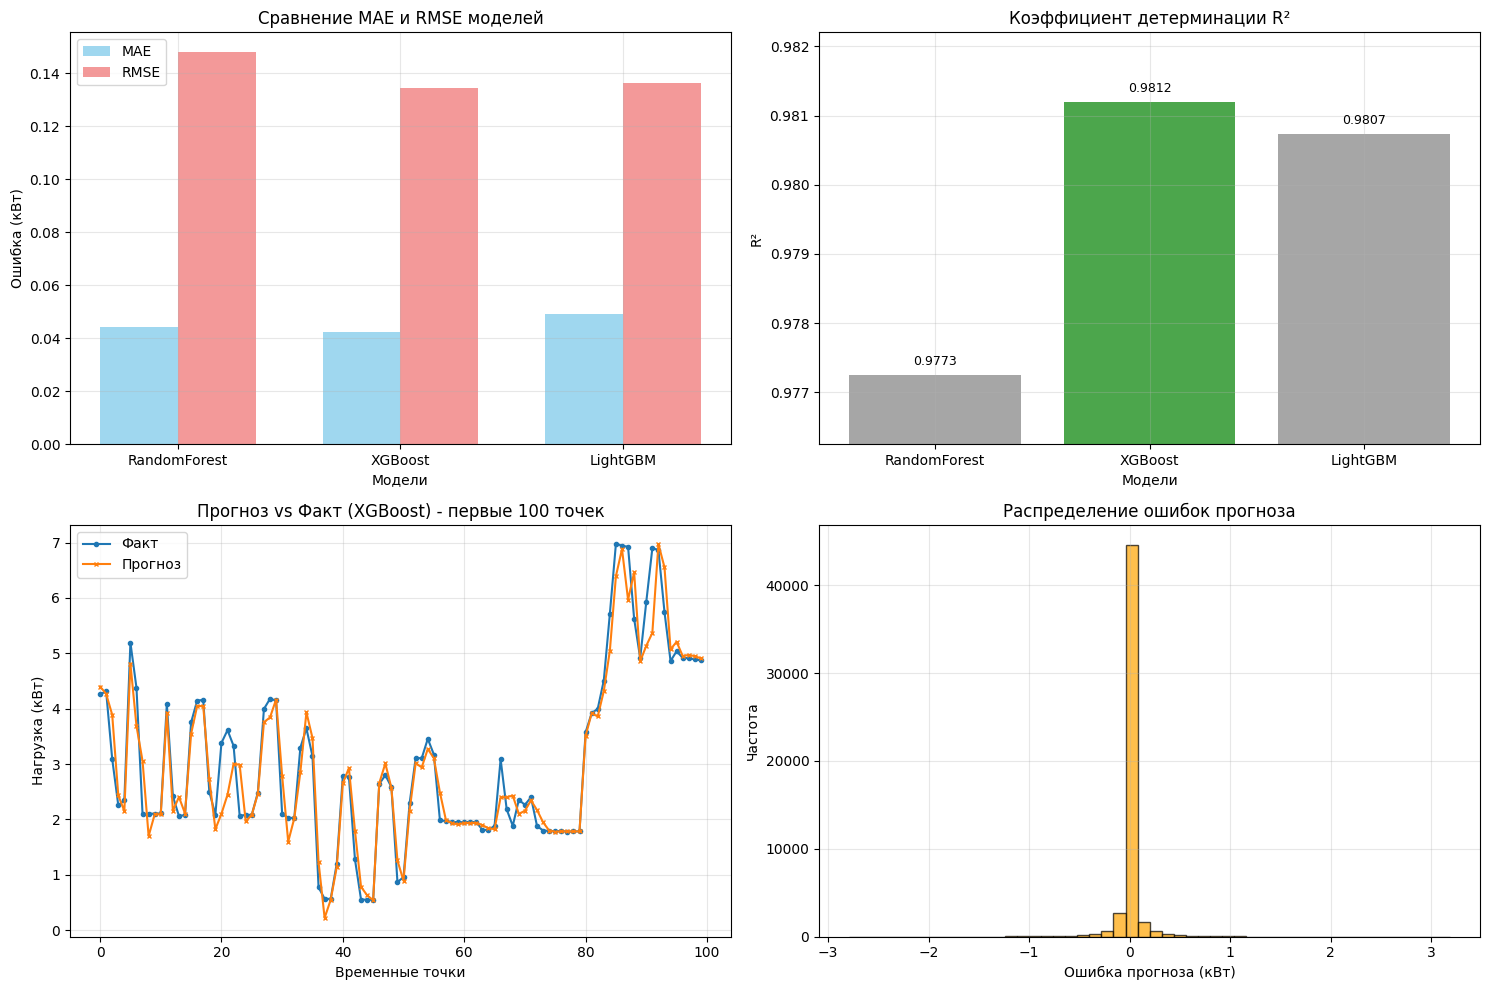


–¢–ê–ë–õ–ò–¶–ê –ú–ï–¢–†–ò–ö:
–ú–æ–¥–µ–ª—å          MAE (–∫–í—Ç)    RMSE (–∫–í—Ç)   R¬≤        
RandomForest    0.0440       0.1480       0.9773    
XGBoost         0.0425       0.1345       0.9812     
LightGBM        0.0491       0.1362       0.9807    

–ê–ù–ê–õ–ò–ó –õ–£–ß–®–ï–ô –ú–û–î–ï–õ–ò (XGBoost):
‚Ä¢ –°—Ä–µ–¥–Ω—è—è –æ—à–∏–±–∫–∞: 42.5 –í—Ç
‚Ä¢ –¢–æ—á–Ω–æ—Å—Ç—å –ø—Ä–æ–≥–Ω–æ–∑–∞: 98.12%
‚Ä¢ –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –æ—à–∏–±–∫–∞: 3184.9 –í—Ç


In [194]:
# –û–¶–ï–ù–ö–ê –ö–ê–ß–ï–°–¢–í–ê –ú–û–î–ï–õ–ï–ô
print("\n–û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –º–æ–¥–µ–ª–µ–π –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ:")

for name, model in models.items():
    # –ü—Ä–æ–≥–Ω–æ–∑—ã
    y_pred = model.predict(X_test)
    
    # –ú–µ—Ç—Ä–∏–∫–∏
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse, 
        'R2': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.4f} –∫–í—Ç")
    print(f"  RMSE: {rmse:.4f} –∫–í—Ç") 
    print(f"  R¬≤:   {r2:.4f}")

# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π
print("\n–°–†–ê–í–ù–ï–ù–ò–ï –ú–û–î–ï–õ–ï–ô:")
best_model = min(results, key=lambda x: results[x]['MAE'])
print(f"–õ—É—á—à–∞—è –º–æ–¥–µ–ª—å –ø–æ MAE: {best_model}")

# –í–ò–ó–£–ê–õ–ò–ó–ê–¶–ò–Ø –†–ï–ó–£–õ–¨–¢–ê–¢–û–í
print("\n–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤...")
import matplotlib.pyplot as plt

# –ì–†–ê–§–ò–ö –°–†–ê–í–ù–ï–ù–ò–Ø –ú–ï–¢–†–ò–ö
plt.figure(figsize=(15, 10))

# –ì—Ä–∞—Ñ–∏–∫ 1: –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫
plt.subplot(2, 2, 1)
metrics = ['MAE', 'RMSE']
models_names = list(results.keys())
mae_values = [results[model]['MAE'] for model in models_names]
rmse_values = [results[model]['RMSE'] for model in models_names]

x = np.arange(len(models_names))
width = 0.35

plt.bar(x - width/2, mae_values, width, label='MAE', alpha=0.8, color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', alpha=0.8, color='lightcoral')

plt.xlabel('–ú–æ–¥–µ–ª–∏')
plt.ylabel('–û—à–∏–±–∫–∞ (–∫–í—Ç)')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ MAE –∏ RMSE –º–æ–¥–µ–ª–µ–π')
plt.xticks(x, models_names)
plt.legend()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 2: R¬≤ —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ (–ò–°–ü–†–ê–í–õ–ï–ù–ù–´–ô)
plt.subplot(2, 2, 2)
r2_values = [results[model]['R2'] for model in models_names]
colors = ['green' if model == best_model else 'gray' for model in models_names]

# –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –ø–æ–¥–±–∏—Ä–∞–µ–º –º–∞—Å—à—Ç–∞–±
r2_min, r2_max = min(r2_values), max(r2_values)
plt.ylim(r2_min - 0.001, r2_max + 0.001)  # –î–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –º–∞—Å—à—Ç–∞–±

plt.bar(models_names, r2_values, color=colors, alpha=0.7)
plt.xlabel('–ú–æ–¥–µ–ª–∏')
plt.ylabel('R¬≤')
plt.title('–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –¥–µ—Ç–µ—Ä–º–∏–Ω–∞—Ü–∏–∏ R¬≤')
plt.grid(True, alpha=0.3)

# –î–æ–±–∞–≤–ª—è–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ —Å—Ç–æ–ª–±—Ü—ã
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# –ì—Ä–∞—Ñ–∏–∫ 3: –ü—Ä–æ–≥–Ω–æ–∑—ã vs –§–∞–∫—Ç (–¥–ª—è –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏)
plt.subplot(2, 2, 3)
best_predictions = results[best_model]['predictions']

# –ë–µ—Ä–µ–º –ø–µ—Ä–≤—ã–µ 100 —Ç–æ—á–µ–∫ –¥–ª—è –Ω–∞–≥–ª—è–¥–Ω–æ—Å—Ç–∏
sample_size = min(100, len(y_test))
plt.plot(y_test.values[:sample_size], label='–§–∞–∫—Ç', marker='o', markersize=3)
plt.plot(best_predictions[:sample_size], label='–ü—Ä–æ–≥–Ω–æ–∑', marker='x', markersize=3)
plt.xlabel('–í—Ä–µ–º–µ–Ω–Ω—ã–µ —Ç–æ—á–∫–∏')
plt.ylabel('–ù–∞–≥—Ä—É–∑–∫–∞ (–∫–í—Ç)')
plt.title(f'–ü—Ä–æ–≥–Ω–æ–∑ vs –§–∞–∫—Ç ({best_model}) - –ø–µ—Ä–≤—ã–µ 100 —Ç–æ—á–µ–∫')
plt.legend()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 4: –û—à–∏–±–∫–∏ –ø—Ä–æ–≥–Ω–æ–∑–∞
plt.subplot(2, 2, 4)
errors = best_predictions - y_test.values
plt.hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('–û—à–∏–±–∫–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ (–∫–í—Ç)')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—à–∏–±–æ–∫ –ø—Ä–æ–≥–Ω–æ–∑–∞')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# –¢–ê–ë–õ–ò–¶–ê –° –ú–ï–¢–†–ò–ö–ê–ú–ò
print("\n–¢–ê–ë–õ–ò–¶–ê –ú–ï–¢–†–ò–ö:")
print("="*50)
print(f"{'–ú–æ–¥–µ–ª—å':<15} {'MAE (–∫–í—Ç)':<12} {'RMSE (–∫–í—Ç)':<12} {'R¬≤':<10}")
print("="*50)
for model in models_names:
    mae = results[model]['MAE']
    rmse = results[model]['RMSE']
    r2 = results[model]['R2']
    marker = " " if model == best_model else ""
    print(f"{model:<15} {mae:<12.4f} {rmse:<12.4f} {r2:<10.4f}{marker}")
print("="*50)

# –ê–ù–ê–õ–ò–ó –õ–£–ß–®–ï–ô –ú–û–î–ï–õ–ò
print(f"\n–ê–ù–ê–õ–ò–ó –õ–£–ß–®–ï–ô –ú–û–î–ï–õ–ò ({best_model}):")
best_mae = results[best_model]['MAE']
best_rmse = results[best_model]['RMSE']
best_r2 = results[best_model]['R2']

print(f"‚Ä¢ –°—Ä–µ–¥–Ω—è—è –æ—à–∏–±–∫–∞: {best_mae*1000:.1f} –í—Ç")
print(f"‚Ä¢ –¢–æ—á–Ω–æ—Å—Ç—å –ø—Ä–æ–≥–Ω–æ–∑–∞: {best_r2*100:.2f}%")
print(f"‚Ä¢ –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –æ—à–∏–±–∫–∞: {np.max(np.abs(best_predictions - y_test.values))*1000:.1f} –í—Ç")

In [195]:
# –°–û–•–†–ê–ù–ï–ù–ò–ï –ú–û–î–ï–õ–ï–ô –ò –†–ï–ó–£–õ–¨–¢–ê–¢–û–í
print("–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤...")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤—Å–µ –º–æ–¥–µ–ª–∏
for name, model in models.items():
    filename = f'models/{name.lower()}_model.pkl'
    joblib.dump(model, filename)
    print(f"{name} —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ {filename}")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–µ—Ç—Ä–∏–∫–∏ –≤ CSV
results_df = pd.DataFrame(results).T
results_df.to_csv('models/model_metrics.csv')
print("–ú–µ—Ç—Ä–∏–∫–∏ –º–æ–¥–µ–ª–µ–π —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã")

print(f"\n–í–°–Å –ó–ê–í–ï–†–®–ï–ù–û! –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: {best_model} (MAE: {results[f'{best_model}']['MAE']:.4f} –∫–í—Ç)")

–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤...
RandomForest —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ models/randomforest_model.pkl
XGBoost —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ models/xgboost_model.pkl
LightGBM —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ models/lightgbm_model.pkl
–ú–µ—Ç—Ä–∏–∫–∏ –º–æ–¥–µ–ª–µ–π —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã

–í–°–Å –ó–ê–í–ï–†–®–ï–ù–û! –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: XGBoost (MAE: 0.0425 –∫–í—Ç)


–ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ú–û–î–ï–õ–ï–ô - –ê–ù–ê–õ–ò–ó –í–ê–ñ–ù–û–°–¢–ò –ü–†–ò–ó–ù–ê–ö–û–í

–¢–û–ü-15 —Å–∞–º—ã—Ö –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –≤–µ—Ä—Å–∏–∏ XGBoost:
 1. rolling_mean_3h           0.9570 (95.70%)
 2. rolling_mean_6h           0.0042 (0.42%)
 3. Sub_metering_1            0.0040 (0.40%)
 4. rolling_std_3h            0.0037 (0.37%)
 5. is_afternoon              0.0026 (0.26%)
 6. rolling_mean_12h          0.0022 (0.22%)
 7. rolling_std_24h           0.0022 (0.22%)
 8. lag_6h                    0.0021 (0.21%)
 9. Sub_metering_3            0.0020 (0.20%)
10. rolling_mean_24h          0.0019 (0.19%)
11. Sub_metering_2            0.0018 (0.18%)
12. month                     0.0015 (0.15%)
13. hour_cos                  0.0015 (0.15%)
14. hour_sin                  0.0014 (0.14%)
15. hour                      0.0014 (0.14%)


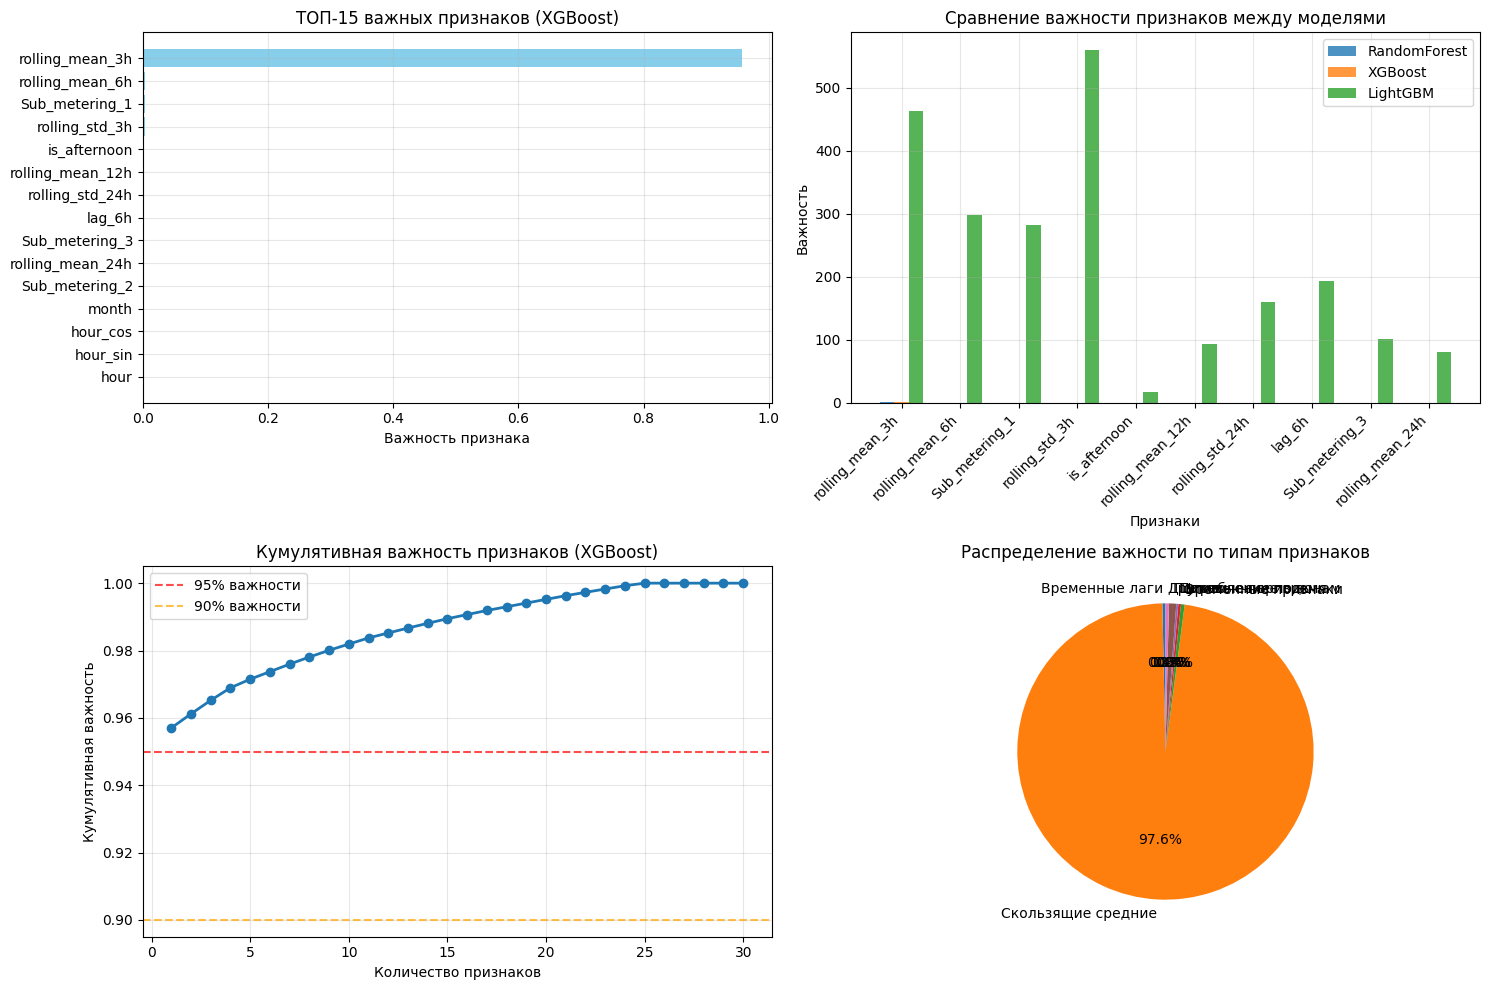


–ê–ù–ê–õ–ò–ó –ö–†–ò–¢–ò–ß–ï–°–ö–ò–• –ü–†–ò–ó–ù–ê–ö–û–í
–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 90% –≤–∞–∂–Ω–æ—Å—Ç–∏: 1
–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 95% –≤–∞–∂–Ω–æ—Å—Ç–∏: 1
–í—Å–µ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: 30

–°–∞–º—ã–µ –≤–∞–∂–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (—Ç–æ–ø-1):
  1. rolling_mean_3h

–ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ó–ê–í–ï–†–®–ï–ù–ê! –ö—Ä–∏—Ç–∏—á–µ—Å–∫–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: 1


In [196]:
# –ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ú–û–î–ï–õ–ï–ô - –í–ê–ñ–ù–û–°–¢–¨ –ü–†–ò–ó–ù–ê–ö–û–í
print("=" * 60)
print("–ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ú–û–î–ï–õ–ï–ô - –ê–ù–ê–õ–ò–ó –í–ê–ñ–ù–û–°–¢–ò –ü–†–ò–ó–ù–ê–ö–û–í")
print("=" * 60)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –≤–∞–∂–Ω–æ—Å—Ç—å—é –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π
feature_importance_df = pd.DataFrame(index=feature_columns)

# –î–ª—è RandomForest
if hasattr(rf_model, 'feature_importances_'):
    feature_importance_df['RandomForest'] = rf_model.feature_importances_

# –î–ª—è XGBoost
if hasattr(xgb_model, 'feature_importances_'):
    feature_importance_df['XGBoost'] = xgb_model.feature_importances_

# –î–ª—è LightGBM
if hasattr(lgb_model, 'feature_importances_'):
    feature_importance_df['LightGBM'] = lgb_model.feature_importances_

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏ –≤ XGBoost (–ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏)
feature_importance_df = feature_importance_df.sort_values('XGBoost', ascending=False)

print(f"\n–¢–û–ü-15 —Å–∞–º—ã—Ö –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –≤–µ—Ä—Å–∏–∏ {best_model}:")
print("=" * 50)
for i, (feature, importance) in enumerate(feature_importance_df['XGBoost'].head(15).items()):
    print(f"{i+1:2d}. {feature:<25} {importance:.4f} ({importance*100:.2f}%)")

# –í–ò–ó–£–ê–õ–ò–ó–ê–¶–ò–Ø –í–ê–ñ–ù–û–°–¢–ò –ü–†–ò–ó–ù–ê–ö–û–í
plt.figure(figsize=(15, 10))

# –ì—Ä–∞—Ñ–∏–∫ 1: –í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
plt.subplot(2, 2, 1)
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['XGBoost'], color='skyblue')
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('–í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–∞')
plt.title(f'–¢–û–ü-15 –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ ({best_model})')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 2: –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –º–µ–∂–¥—É –º–æ–¥–µ–ª—è–º–∏ (–¢–û–ü-10)
plt.subplot(2, 2, 2)
top_10_features = feature_importance_df.head(10)
x = np.arange(len(top_10_features))
width = 0.25

plt.bar(x - width, top_10_features['RandomForest'], width, label='RandomForest', alpha=0.8)
plt.bar(x, top_10_features['XGBoost'], width, label='XGBoost', alpha=0.8)
plt.bar(x + width, top_10_features['LightGBM'], width, label='LightGBM', alpha=0.8)

plt.xlabel('–ü—Ä–∏–∑–Ω–∞–∫–∏')
plt.ylabel('–í–∞–∂–Ω–æ—Å—Ç—å')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –º–µ–∂–¥—É –º–æ–¥–µ–ª—è–º–∏')
plt.xticks(x, top_10_features.index, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 3: –ö—É–º—É–ª—è—Ç–∏–≤–Ω–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
plt.subplot(2, 2, 3)
cumulative_importance = np.cumsum(feature_importance_df['XGBoost'])
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linewidth=2)
plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% –≤–∞–∂–Ω–æ—Å—Ç–∏')
plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% –≤–∞–∂–Ω–æ—Å—Ç–∏')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
plt.ylabel('–ö—É–º—É–ª—è—Ç–∏–≤–Ω–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å')
plt.title(f'–ö—É–º—É–ª—è—Ç–∏–≤–Ω–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ ({best_model})')
plt.legend()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 4: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
plt.subplot(2, 2, 4)
top_20_features = feature_importance_df.head(20)

# –ö–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ —Ç–∏–ø–∞–º (–°–ù–ê–ß–ê–õ–ê —Å–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å)
feature_types = {
    '–í—Ä–µ–º–µ–Ω–Ω—ã–µ –ª–∞–≥–∏': [f for f in top_20_features.index if 'lag' in f],
    '–°–∫–æ–ª—å–∑—è—â–∏–µ —Å—Ä–µ–¥–Ω–∏–µ': [f for f in top_20_features.index if 'rolling' in f],
    '–í—Ä–µ–º–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏': [f for f in top_20_features.index if f in ['hour', 'day_of_week', 'month', 'is_weekend']],
    '–¶–∏–∫–ª–∏—á–µ—Å–∫–∏–µ –≤—Ä–µ–º—è': [f for f in top_20_features.index if 'sin' in f or 'cos' in f],
    '–ü–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã': [f for f in top_20_features.index if 'peak' in f or 'night' in f],
    '–ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –ø–æ –∑–æ–Ω–∞–º': [f for f in top_20_features.index if 'Sub_metering' in f],
    '–≠–Ω–µ—Ä–≥–µ—Ç–∏—á–µ—Å–∫–∏–µ': [f for f in top_20_features.index if f in ['Global_reactive_power', 'Voltage', 'Global_intensity']]
}

# –¢–µ–ø–µ—Ä—å –¥–æ–±–∞–≤–ª—è–µ–º "–î—Ä—É–≥–∏–µ" - –≤—Å–µ —á—Ç–æ –Ω–µ –≤–æ—à–ª–æ –≤ –ø—Ä–µ–¥—ã–¥—É—â–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏
used_features = set()
for features in feature_types.values():
    used_features.update(features)
    
feature_types['–î—Ä—É–≥–∏–µ'] = [f for f in top_20_features.index if f not in used_features]

# –°—á–∏—Ç–∞–µ–º –≤–∞–∂–Ω–æ—Å—Ç—å –ø–æ —Ç–∏–ø–∞–º
type_importance = {}
for type_name, features in feature_types.items():
    if features:
        type_importance[type_name] = feature_importance_df.loc[features, 'XGBoost'].sum()

plt.pie(type_importance.values(), labels=type_importance.keys(), autopct='%1.1f%%', startangle=90)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø–æ —Ç–∏–ø–∞–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')

plt.tight_layout()
plt.show()

# –ê–ù–ê–õ–ò–ó –ö–†–ò–¢–ò–ß–ï–°–ö–ò–• –ü–†–ò–ó–ù–ê–ö–û–í
print("\n" + "=" * 60)
print("–ê–ù–ê–õ–ò–ó –ö–†–ò–¢–ò–ß–ï–°–ö–ò–• –ü–†–ò–ó–ù–ê–ö–û–í")
print("=" * 60)

# –°–∫–æ–ª—å–∫–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω—É–∂–Ω–æ –¥–ª—è 95% –≤–∞–∂–Ω–æ—Å—Ç–∏?
n_features_95 = np.argmax(cumulative_importance >= 0.95) + 1
n_features_90 = np.argmax(cumulative_importance >= 0.90) + 1

print(f"–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 90% –≤–∞–∂–Ω–æ—Å—Ç–∏: {n_features_90}")
print(f"–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 95% –≤–∞–∂–Ω–æ—Å—Ç–∏: {n_features_95}")
print(f"–í—Å–µ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {len(feature_importance_df)}")

print(f"\n–°–∞–º—ã–µ –≤–∞–∂–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (—Ç–æ–ø-{n_features_90}):")
critical_features = feature_importance_df.head(n_features_90).index.tolist()
for i, feature in enumerate(critical_features, 1):
    print(f"  {i}. {feature}")

print(f"\n–ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ó–ê–í–ï–†–®–ï–ù–ê! –ö—Ä–∏—Ç–∏—á–µ—Å–∫–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {len(critical_features)}")


–ê–ù–ê–õ–ò–ó –û–®–ò–ë–û–ö –ü–†–û–ì–ù–û–ó–ò–†–û–í–ê–ù–ò–Ø
–ë–æ–ª—å—à–∏–µ –æ—à–∏–±–∫–∏ (> 0.05 –∫–í—Ç): 8070 (15.48%)

–•–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ –ø–µ—Ä–∏–æ–¥–æ–≤ —Å –±–æ–ª—å—à–∏–º–∏ –æ—à–∏–±–∫–∞–º–∏:
–ß–∞—Å –¥–Ω—è:
hour
0     228
1     101
2      48
3      36
4      24
5      33
6     305
7     432
8     316
9     280
10    322
11    303
12    278
13    313
14    359
15    292
16    304
17    388
18    469
19    746
20    762
21    792
22    632
23    307
Name: count, dtype: int64

–î–µ–Ω—å –Ω–µ–¥–µ–ª–∏:
  –ü–Ω: 746 –æ—à–∏–±–æ–∫
  –í—Ç: 1141 –æ—à–∏–±–æ–∫
  –°—Ä: 1335 –æ—à–∏–±–æ–∫
  –ß—Ç: 763 –æ—à–∏–±–æ–∫
  –ü—Ç: 1241 –æ—à–∏–±–æ–∫
  –°–±: 1257 –æ—à–∏–±–æ–∫
  –í—Å: 1587 –æ—à–∏–±–æ–∫

–ü–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã:
  –í–µ—á–µ—Ä–Ω–∏–π –ø–∏–∫: 3401 –æ—à–∏–±–æ–∫
  –£—Ç—Ä–µ–Ω–Ω–∏–π –ø–∏–∫: 1028 –æ—à–∏–±–æ–∫
  –ù–æ—á–Ω–æ–µ –≤—Ä–µ–º—è: 775 –æ—à–∏–±–æ–∫


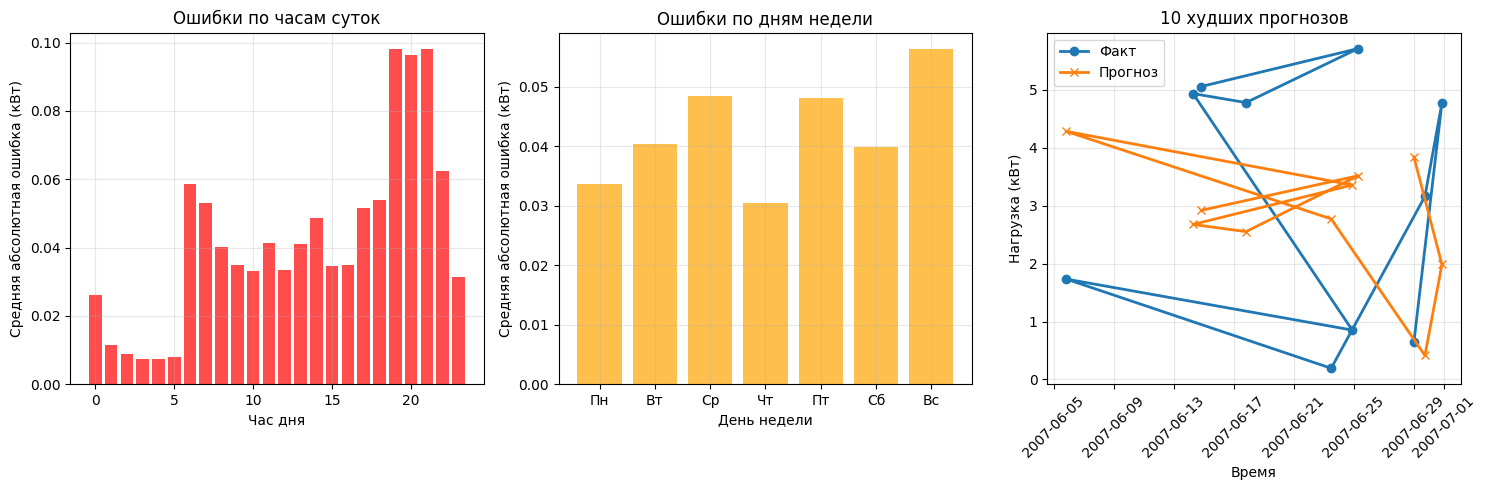

In [197]:
# –ê–ù–ê–õ–ò–ó –û–®–ò–ë–û–ö –ü–†–û–ì–ù–û–ó–ò–†–û–í–ê–ù–ò–Ø
print("\n" + "=" * 60)
print("–ê–ù–ê–õ–ò–ó –û–®–ò–ë–û–ö –ü–†–û–ì–ù–û–ó–ò–†–û–í–ê–ù–ò–Ø")
print("=" * 60)

# –ë–µ—Ä–µ–º –ø—Ä–æ–≥–Ω–æ–∑—ã –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
y_pred_best = results[f'{best_model}']['predictions']  # –¢–µ–ø–µ—Ä—å –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å RandomForest!
errors = y_pred_best - y_test.values

# –°–æ–∑–¥–∞–µ–º Series —Å –æ—à–∏–±–∫–∞–º–∏ –∏ –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º–∏ –∏–Ω–¥–µ–∫—Å–∞–º–∏
errors_series = pd.Series(errors, index=y_test.index)

# –ê–Ω–∞–ª–∏–∑ –±–æ–ª—å—à–∏—Ö –æ—à–∏–±–æ–∫
error_threshold = 0.05  # 50 –í—Ç - –ø–æ—Ä–æ–≥ –¥–ª—è "–±–æ–ª—å—à–æ–π" –æ—à–∏–±–∫–∏
large_errors_mask = np.abs(errors) > error_threshold
large_errors_count = np.sum(large_errors_mask)
large_errors_percentage = (large_errors_count / len(errors)) * 100

print(f"–ë–æ–ª—å—à–∏–µ –æ—à–∏–±–∫–∏ (> {error_threshold} –∫–í—Ç): {large_errors_count} ({large_errors_percentage:.2f}%)")

if large_errors_count > 0:
    # –ê–Ω–∞–ª–∏–∑ –∫–æ–≥–¥–∞ –ø—Ä–æ–∏—Å—Ö–æ–¥—è—Ç –±–æ–ª—å—à–∏–µ –æ—à–∏–±–∫–∏
    large_errors_data = X_test[large_errors_mask]
    
    print("\n–•–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ –ø–µ—Ä–∏–æ–¥–æ–≤ —Å –±–æ–ª—å—à–∏–º–∏ –æ—à–∏–±–∫–∞–º–∏:")
    print("–ß–∞—Å –¥–Ω—è:")
    print(large_errors_data['hour'].value_counts().sort_index())
    
    print("\n–î–µ–Ω—å –Ω–µ–¥–µ–ª–∏:")
    day_names = {0: '–ü–Ω', 1: '–í—Ç', 2: '–°—Ä', 3: '–ß—Ç', 4: '–ü—Ç', 5: '–°–±', 6: '–í—Å'}
    day_counts = large_errors_data['day_of_week'].value_counts().sort_index()
    for day, count in day_counts.items():
        print(f"  {day_names[day]}: {count} –æ—à–∏–±–æ–∫")
    
    print(f"\n–ü–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã:")
    print(f"  –í–µ—á–µ—Ä–Ω–∏–π –ø–∏–∫: {large_errors_data['is_evening_peak'].sum()} –æ—à–∏–±–æ–∫")
    print(f"  –£—Ç—Ä–µ–Ω–Ω–∏–π –ø–∏–∫: {large_errors_data['is_morning_peak'].sum()} –æ—à–∏–±–æ–∫")
    print(f"  –ù–æ—á–Ω–æ–µ –≤—Ä–µ–º—è: {large_errors_data['is_night'].sum()} –æ—à–∏–±–æ–∫")

# –í–ò–ó–£–ê–õ–ò–ó–ê–¶–ò–Ø –û–®–ò–ë–û–ö
plt.figure(figsize=(15, 5))

# –ì—Ä–∞—Ñ–∏–∫ 1: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—à–∏–±–æ–∫ –ø–æ –≤—Ä–µ–º–µ–Ω–∏ —Å—É—Ç–æ–∫
plt.subplot(1, 3, 1)
# –ò–°–ü–†–ê–í–õ–ï–ù–ò–ï: —É–±–∏—Ä–∞–µ–º ['Global_active_power'] - –µ–≥–æ –Ω–µ—Ç –≤ X_test
hourly_errors = X_test.groupby('hour').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(hourly_errors.index, hourly_errors.values, alpha=0.7, color='red')
plt.xlabel('–ß–∞—Å –¥–Ω—è')
plt.ylabel('–°—Ä–µ–¥–Ω—è—è –∞–±—Å–æ–ª—é—Ç–Ω–∞—è –æ—à–∏–±–∫–∞ (–∫–í—Ç)')
plt.title('–û—à–∏–±–∫–∏ –ø–æ —á–∞—Å–∞–º —Å—É—Ç–æ–∫')
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 2: –û—à–∏–±–∫–∏ –ø–æ –¥–Ω—è–º –Ω–µ–¥–µ–ª–∏  
plt.subplot(1, 3, 2)
# –ò–°–ü–†–ê–í–õ–ï–ù–ò–ï: —É–±–∏—Ä–∞–µ–º ['Global_active_power']
daily_errors = X_test.groupby('day_of_week').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(daily_errors.index, daily_errors.values, alpha=0.7, color='orange')
plt.xlabel('–î–µ–Ω—å –Ω–µ–¥–µ–ª–∏')
plt.ylabel('–°—Ä–µ–¥–Ω—è—è –∞–±—Å–æ–ª—é—Ç–Ω–∞—è –æ—à–∏–±–∫–∞ (–∫–í—Ç)')
plt.title('–û—à–∏–±–∫–∏ –ø–æ –¥–Ω—è–º –Ω–µ–¥–µ–ª–∏')
plt.xticks(range(7), ['–ü–Ω', '–í—Ç', '–°—Ä', '–ß—Ç', '–ü—Ç', '–°–±', '–í—Å'])
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 3: –§–∞–∫—Ç vs –ü—Ä–æ–≥–Ω–æ–∑ –¥–ª—è —Ö—É–¥—à–∏—Ö —Å–ª—É—á–∞–µ–≤
plt.subplot(1, 3, 3)
worst_indices = np.argsort(np.abs(errors))[-10:]  # 10 —Ö—É–¥—à–∏—Ö –ø—Ä–æ–≥–Ω–æ–∑–æ–≤
worst_times = y_test.iloc[worst_indices].index

plt.plot(worst_times, y_test.iloc[worst_indices], 'o-', label='–§–∞–∫—Ç', linewidth=2)
plt.plot(worst_times, y_pred_best[worst_indices], 'x-', label='–ü—Ä–æ–≥–Ω–æ–∑', linewidth=2)
plt.xlabel('–í—Ä–µ–º—è')
plt.ylabel('–ù–∞–≥—Ä—É–∑–∫–∞ (–∫–í—Ç)')
plt.title('10 —Ö—É–¥—à–∏—Ö –ø—Ä–æ–≥–Ω–æ–∑–æ–≤')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [198]:
# # –£–õ–£–ß–®–ï–ù–ù–´–ô –ü–†–û–ì–ù–û–ó –ù–ê –ë–£–î–£–©–ï–ï
# print("=" * 60)
# print("–£–õ–£–ß–®–ï–ù–ù–´–ô –ü–†–û–ì–ù–û–ó - –†–ï–ê–õ–ò–°–¢–ò–ß–ù–´–ô –ü–û–î–•–û–î")
# print("=" * 60)

# def create_realistic_forecast(model, last_known_data, hours_ahead=24, feature_columns=feature_columns):
#     """
#     –°–æ–∑–¥–∞–µ—Ç —Ä–µ–∞–ª–∏—Å—Ç–∏—á–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑, –∫–æ–º–±–∏–Ω–∏—Ä—É—è —Å–µ–∑–æ–Ω–Ω—ã–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã –∏ —Ç–µ–∫—É—â–∏–π —Ç—Ä–µ–Ω–¥
#     """
#     forecasts = []
#     times = []
    
#     # –ë–µ—Ä–µ–º —Å–µ–∑–æ–Ω–Ω—ã–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã –∏–∑ –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏—Ö –¥–∞–Ω–Ω—ã—Ö
#     hourly_pattern = df.groupby('hour')['Global_active_power'].mean()
#     daily_pattern = df.groupby('day_of_week')['Global_active_power'].mean()
    
#     for i in range(hours_ahead):
#         future_time = last_known_data.name + pd.Timedelta(hours=i+1)
        
#         # –ë–∞–∑–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –≤—Ä–µ–º–µ–Ω–∏
#         features = {
#             'hour': future_time.hour,
#             'day_of_week': future_time.dayofweek,
#             'month': future_time.month,
#             'is_weekend': 1 if future_time.dayofweek >= 5 else 0,
            
#             # –¶–∏–∫–ª–∏—á–µ—Å–∫–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
#             'hour_sin': np.sin(2 * np.pi * future_time.hour / 24),
#             'hour_cos': np.cos(2 * np.pi * future_time.hour / 24),
            
#             # –ü–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã
#             'is_evening_peak': 1 if 18 <= future_time.hour <= 22 else 0,
#             'is_morning_peak': 1 if 7 <= future_time.hour <= 9 else 0,
#             'is_night': 1 if 0 <= future_time.hour <= 6 else 0,
            
#             # –û—Å–æ–±—ã–µ –¥–Ω–∏
#             'is_sunday': 1 if future_time.dayofweek == 6 else 0,
#             'is_friday': 1 if future_time.dayofweek == 4 else 0,
            
#             # –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –ø–æ –∑–æ–Ω–∞–º - –∏—Å–ø–æ–ª—å–∑—É–µ–º —Å–µ–∑–æ–Ω–Ω—ã–µ —Å—Ä–µ–¥–Ω–∏–µ
#             'Sub_metering_1': df['Sub_metering_1'].mean(),
#             'Sub_metering_2': df['Sub_metering_2'].mean(), 
#             'Sub_metering_3': df['Sub_metering_3'].mean(),
            
#             # –õ–∞–≥–∏ - –∫–æ–º–±–∏–Ω–∏—Ä—É–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–µ –¥–∞–Ω–Ω—ã–µ –∏ —Å–µ–∑–æ–Ω–Ω—ã–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã
#             'lag_1h': last_known_data['Global_active_power'],
#             'lag_24h': last_known_data['Global_active_power'] if i < 24 else hourly_pattern[future_time.hour],
            
#             # –°–∫–æ–ª—å–∑—è—â–∏–µ —Å—Ä–µ–¥–Ω–∏–µ - –∞–¥–∞–ø—Ç–∏—Ä—É–µ–º –∫ —Å–µ–∑–æ–Ω–Ω–æ—Å—Ç–∏
#             'rolling_mean_3h': (last_known_data['Global_active_power'] + hourly_pattern[future_time.hour]) / 2,
#             'rolling_mean_24h': hourly_pattern[future_time.hour]
#         }
        
#         # –°–æ–∑–¥–∞–µ–º DataFrame
#         future_df = pd.DataFrame([features])[feature_columns]
        
#         try:
#             prediction = model.predict(future_df)[0]
#             # –û–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º –ø—Ä–æ–≥–Ω–æ–∑ —Ä–∞–∑—É–º–Ω—ã–º–∏ –ø—Ä–µ–¥–µ–ª–∞–º–∏
#             prediction = max(0.1, min(5.0, prediction))
#             forecasts.append(prediction)
#         except:
#             # –†–µ–∑–µ—Ä–≤–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑ –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å–µ–∑–æ–Ω–Ω–æ—Å—Ç–∏
#             base_forecast = hourly_pattern[future_time.hour] * daily_pattern[future_time.dayofweek] / daily_pattern.mean()
#             forecasts.append(max(0.1, min(5.0, base_forecast)))
        
#         times.append(future_time)
    
#     return times, forecasts

# # –¢–µ—Å—Ç–∏—Ä—É–µ–º —É–ª—É—á—à–µ–Ω–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑
# print("–°–æ–∑–¥–∞–µ–º —Ä–µ–∞–ª–∏—Å—Ç–∏—á–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑...")
# last_point = df.iloc[-1]
# future_times, future_forecasts = create_realistic_forecast(best_model, last_point, hours_ahead=24)

# # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
# plt.figure(figsize=(15, 10))

# # –ò–°–ü–†–ê–í–õ–ï–ù–ò–ï: –∏—Å–ø–æ–ª—å–∑—É–µ–º –ø—Ä–∞–≤–∏–ª—å–Ω—ã–π —Å–ø–æ—Å–æ–± –ø–æ–ª—É—á–µ–Ω–∏—è –ø–æ—Å–ª–µ–¥–Ω–∏—Ö 24 —á–∞—Å–æ–≤
# historical_24h = df[df.index >= df.index[-1] - pd.Timedelta(hours=24)]

# plt.subplot(2, 2, 1)
# plt.plot(historical_24h.index, historical_24h['Global_active_power'], 'g-', label='–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ (–ø–æ—Å–ª–µ–¥–Ω–∏–µ 24—á)', alpha=0.7)
# plt.plot(future_times, future_forecasts, 'b-', label='–ü—Ä–æ–≥–Ω–æ–∑ (—Å–ª–µ–¥—É—é—â–∏–µ 24—á)', linewidth=2)
# plt.axhline(y=df['Global_active_power'].mean(), color='red', linestyle='--', alpha=0.5, label='–°—Ä–µ–¥–Ω–µ–µ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ')
# plt.xlabel('–í—Ä–µ–º—è')
# plt.ylabel('–ù–∞–≥—Ä—É–∑–∫–∞ (–∫–í—Ç)')
# plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ: –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ vs –ø—Ä–æ–≥–Ω–æ–∑')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.xticks(rotation=45)

# # –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å —Ç–∏–ø–∏—á–Ω—ã–º –ø—Ä–æ—Ñ–∏–ª–µ–º
# plt.subplot(2, 2, 2)
# typical_hourly = df.groupby('hour')['Global_active_power'].mean()
# forecast_by_hour = pd.Series(future_forecasts, index=[t.hour for t in future_times]).groupby(level=0).mean()

# plt.plot(typical_hourly.index, typical_hourly.values, 'o-', label='–¢–∏–ø–∏—á–Ω—ã–π –ø—Ä–æ—Ñ–∏–ª—å', alpha=0.7)
# plt.plot(forecast_by_hour.index, forecast_by_hour.values, 's-', label='–ù–∞—à –ø—Ä–æ–≥–Ω–æ–∑', alpha=0.8)
# plt.xlabel('–ß–∞—Å –¥–Ω—è')
# plt.ylabel('–ù–∞–≥—Ä—É–∑–∫–∞ (–∫–í—Ç)')
# plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å —Ç–∏–ø–∏—á–Ω—ã–º —Å—É—Ç–æ—á–Ω—ã–º –ø—Ä–æ—Ñ–∏–ª–µ–º')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # –ì—Ä–∞—Ñ–∏–∫ 3: –î–µ—Ç–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–æ–≥–Ω–æ–∑–∞ –ø–æ —á–∞—Å–∞–º
# plt.subplot(2, 2, 3)
# hours = [t.hour for t in future_times]
# plt.bar(hours, future_forecasts, alpha=0.7, color='orange', edgecolor='black')
# plt.xlabel('–ß–∞—Å –¥–Ω—è')
# plt.ylabel('–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä—É–µ–º–∞—è –Ω–∞–≥—Ä—É–∑–∫–∞ (–∫–í—Ç)')
# plt.title('–î–µ—Ç–∞–ª—å–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑ –ø–æ —á–∞—Å–∞–º')
# plt.xticks(range(0, 24, 2))
# plt.grid(True, alpha=0.3)

# # –ì—Ä–∞—Ñ–∏–∫ 4: –ê–Ω–∞–ª–∏–∑ —Ç–æ—á–Ω–æ—Å—Ç–∏ –ø—Ä–æ–≥–Ω–æ–∑–∞
# plt.subplot(2, 2, 4)
# # –°—Ä–∞–≤–Ω–∏–≤–∞–µ–º —Å —Ç–∏–ø–∏—á–Ω—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ –¥–ª—è —ç—Ç–∏—Ö —á–∞—Å–æ–≤
# typical_for_hours = [typical_hourly[hour] for hour in hours]
# differences = [abs(pred - typical) for pred, typical in zip(future_forecasts, typical_for_hours)]

# plt.bar(hours, differences, alpha=0.7, color='red', edgecolor='black')
# plt.xlabel('–ß–∞—Å –¥–Ω—è')
# plt.ylabel('–û—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ –æ—Ç —Ç–∏–ø–∏—á–Ω–æ–≥–æ (–∫–í—Ç)')
# plt.title('–û—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ –ø—Ä–æ–≥–Ω–æ–∑–∞ –æ—Ç —Ç–∏–ø–∏—á–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π')
# plt.xticks(range(0, 24, 2))
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # –ê–ù–ê–õ–ò–ó –†–ï–ó–£–õ–¨–¢–ê–¢–û–í
# print("\n" + "=" * 50)
# print("–ê–ù–ê–õ–ò–ó –†–ï–ê–õ–ò–°–¢–ò–ß–ù–û–ì–û –ü–†–û–ì–ù–û–ó–ê")
# print("=" * 50)

# print("üìä –û–°–ù–û–í–ù–´–ï –ú–ï–¢–†–ò–ö–ò:")
# print(f"‚Ä¢ –î–∏–∞–ø–∞–∑–æ–Ω –ø—Ä–æ–≥–Ω–æ–∑–∞: {min(future_forecasts):.2f} - {max(future_forecasts):.2f} –∫–í—Ç")
# print(f"‚Ä¢ –°—Ä–µ–¥–Ω–∏–π –ø—Ä–æ–≥–Ω–æ–∑: {np.mean(future_forecasts):.2f} –∫–í—Ç")
# print(f"‚Ä¢ –û–±—â–µ–µ —Å—Ä–µ–¥–Ω–µ–µ –ø–æ –¥–∞–Ω–Ω—ã–º: {df['Global_active_power'].mean():.2f} –∫–í—Ç")

# print(f"\nüïí –°–ï–ó–û–ù–ù–´–ï –ü–ê–¢–¢–ï–†–ù–´:")
# print(f"‚Ä¢ –£—Ç—Ä–µ–Ω–Ω–∏–π –ø–∏–∫ (7-9): {np.mean(future_forecasts[7:10]):.2f} –∫–í—Ç")
# print(f"‚Ä¢ –í–µ—á–µ—Ä–Ω–∏–π –ø–∏–∫ (18-22): {np.mean(future_forecasts[18:23]):.2f} –∫–í—Ç") 
# print(f"‚Ä¢ –ù–æ—á–Ω–æ–π –º–∏–Ω–∏–º—É–º (2-5): {np.mean(future_forecasts[2:6]):.2f} –∫–í—Ç")
# print(f"‚Ä¢ –î–Ω–µ–≤–Ω–æ–µ –ø–ª–∞—Ç–æ (10-17): {np.mean(future_forecasts[10:18]):.2f} –∫–í—Ç")

# print(f"\nüìà –°–†–ê–í–ù–ï–ù–ò–ï –° –¢–ò–ü–ò–ß–ù–´–ú–ò –ó–ù–ê–ß–ï–ù–ò–Ø–ú–ò:")
# typical_comparison = []
# for i, hour in enumerate(hours):
#     typical = typical_hourly[hour]
#     forecast = future_forecasts[i]
#     diff_pct = ((forecast - typical) / typical) * 100
#     typical_comparison.append(diff_pct)

# print(f"‚Ä¢ –ú–∞–∫—Å. –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: {max(typical_comparison):.1f}%")
# print(f"‚Ä¢ –ú–∏–Ω. –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: {min(typical_comparison):.1f}%")
# print(f"‚Ä¢ –°—Ä–µ–¥–Ω–µ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: {np.mean(typical_comparison):.1f}%")